---

## **Deep Learning Project: ConvLSTM Model**
**Name:** Kalsoom Tariq

**Roll number:** i21-2487

**Section:** CS-Z

---

---

### **Import Required Libraries**

---

In [11]:
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from glob import glob
from tqdm import tqdm
import numpy as np
import shutil
import torch
import cv2
import os

---

#### **Data Loading**

---

In [12]:
data_path = "/kaggle/input/ucf101-action-recognition"
save_path = "/kaggle/working/preprocessed_ucf101"

IMG_SIZE = (64, 64)
INPUT_LENGTH = 10
OUTPUT_LENGTH = 5
SELECTED_CLASSES = ['Biking', 'PushUps', 'JumpingJack', 'WalkingWithDog', 'WallPushups']
SEQUENCE_INTERVAL = 2

"""
Preprocess UCF101 videos and save input-output sequences as .npy files for each video.
"""
def preprocess_and_save_ucf101(data_path, save_path, classes, input_length, output_length, sequence_interval):
    os.makedirs(save_path, exist_ok=True)
    for split in ['train', 'val', 'test']:
        for class_name in classes:
            class_path = os.path.join(data_path, split, class_name)
            save_dir = os.path.join(save_path, split, class_name)
            os.makedirs(save_dir, exist_ok=True)

            videos = glob(os.path.join(class_path, '*.avi'))
            print(f"Processing {len(videos)} videos from {class_name} ({split})...")

            for video_path in tqdm(videos):
                # Open video file
                cap = cv2.VideoCapture(video_path)
                frames = []

                # Read frames from video
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break
                    # Convert to grayscale and resize
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    frame = cv2.resize(frame, IMG_SIZE)
                    frames.append(frame)
                cap.release()

                # Check if the video has enough frames for the input-output sequences
                total_frames = len(frames)
                if total_frames >= (input_length + output_length):
                    frames = np.array(frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]

                    # Determine how many sequences can be extracted
                    num_sequences = (total_frames - input_length) // sequence_interval
                    
                    for i in range(num_sequences):
                        start_idx = i * sequence_interval  # The starting frame index of each sequence
                        end_idx = start_idx + input_length + output_length  # End index for the sequence

                        # Ensure that the sequence does not exceed the available frames
                        if end_idx <= total_frames:
                            sequence = frames[start_idx:end_idx]  # Extract the sequence of frames
                            # Save the sequence as a .npy file
                            filename = os.path.join(
                                save_dir,
                                f"{os.path.basename(video_path).replace('.avi', '')}_{i}.npy"
                            )
                            np.save(filename, sequence)
                        else:
                            pass
                            # Skip this interval if we don't have enough frames for a valid sequence
                            # print(f"Skipping sequence from video {video_path}, not enough frames at interval {i}")

    print("Preprocessing complete. Data saved at:", save_path)

In [7]:
preprocess_and_save_ucf101(data_path, save_path, SELECTED_CLASSES, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_INTERVAL)

Processing 100 videos from Biking (train)...


100%|██████████| 100/100 [00:09<00:00, 11.10it/s]


Processing 76 videos from PushUps (train)...


100%|██████████| 76/76 [00:02<00:00, 30.54it/s]


Processing 92 videos from JumpingJack (train)...


100%|██████████| 92/92 [00:03<00:00, 30.61it/s]


Processing 92 videos from WalkingWithDog (train)...


100%|██████████| 92/92 [00:08<00:00, 11.24it/s]


Processing 97 videos from WallPushups (train)...


100%|██████████| 97/97 [00:04<00:00, 19.93it/s]


Processing 17 videos from Biking (val)...


100%|██████████| 17/17 [00:01<00:00, 11.86it/s]


Processing 13 videos from PushUps (val)...


100%|██████████| 13/13 [00:00<00:00, 30.65it/s]


Processing 15 videos from JumpingJack (val)...


100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


Processing 15 videos from WalkingWithDog (val)...


100%|██████████| 15/15 [00:01<00:00, 10.70it/s]


Processing 16 videos from WallPushups (val)...


100%|██████████| 16/16 [00:00<00:00, 21.87it/s]


Processing 17 videos from Biking (test)...


100%|██████████| 17/17 [00:01<00:00, 10.79it/s]


Processing 13 videos from PushUps (test)...


100%|██████████| 13/13 [00:00<00:00, 32.44it/s]


Processing 16 videos from JumpingJack (test)...


100%|██████████| 16/16 [00:00<00:00, 31.08it/s]


Processing 16 videos from WalkingWithDog (test)...


100%|██████████| 16/16 [00:01<00:00, 11.39it/s]


Processing 17 videos from WallPushups (test)...


100%|██████████| 17/17 [00:00<00:00, 21.34it/s]

Preprocessing complete. Data saved at: /kaggle/working/preprocessed_ucf101


---

#### **Data Preparation**

---

In [13]:
class UCF101Dataset(Dataset):
    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (str): Path to the preprocessed data directory.
            split (str): One of 'train', 'val', 'test'.
        """
        self.root_dir = os.path.join(root_dir, split)
        self.files = glob(os.path.join(self.root_dir, '*', '*.npy'))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
        Returns:
            inputs (torch.Tensor): First 10 frames (input sequence).
            targets (torch.Tensor): Last 5 frames (target sequence).
        """
        file_path = self.files[idx]
        sequence = np.load(file_path)
        inputs = torch.tensor(sequence[:10], dtype=torch.float32).unsqueeze(1)
        targets = torch.tensor(sequence[10:], dtype=torch.float32).unsqueeze(1)
        return inputs, targets

# Example usage
dataset = UCF101Dataset(save_path, 'train')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Test the dataloader
inputs, targets = next(iter(dataloader))
print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: torch.Size([16, 10, 1, 64, 64])
Target shape: torch.Size([16, 5, 1, 64, 64])


---

#### **Model Architecture**

---

In [14]:
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, activation, frame_size):
        super(ConvLSTMCell, self).__init__()
        self.activation = torch.tanh if activation == "tanh" else torch.relu
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels,
            out_channels=4 * out_channels,
            kernel_size=kernel_size,
            padding=padding
        )
        self.W_ci = nn.Parameter(torch.zeros(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.zeros(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.zeros(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):
        if H_prev is None:
            H_prev = torch.zeros(X.size(0), self.conv.out_channels // 4, X.size(2), X.size(3), device=X.device)
        if C_prev is None:
            C_prev = torch.zeros_like(H_prev)

        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)
        C = forget_gate * C_prev + input_gate * self.activation(C_conv)
        output_gate = torch.sigmoid(o_conv + self.W_co * C)
        H = output_gate * self.activation(C)

        return H, C


class ConvLSTM(nn.Module):
    def __init__(self, num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_ch = num_channels if i == 0 else num_kernels
            self.layers.append(ConvLSTMCell(in_ch, num_kernels, kernel_size, padding, activation, frame_size))
        self.final_conv = nn.Conv2d(in_channels=num_kernels, out_channels=num_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, X):
        batch_size, seq_len, _, height, width = X.size()
        H, C = [None] * len(self.layers), [None] * len(self.layers)
        outputs = []

        for t in range(seq_len):  # Process each time step
            frame = X[:, t]
            for l, layer in enumerate(self.layers):
                H[l], C[l] = layer(frame, H[l], C[l])
                frame = H[l]
            if t >= seq_len - 5:  # Collect outputs for the last 5 time steps
                outputs.append(self.final_conv(H[-1]))

        return torch.stack(outputs, dim=1)  # Shape: (batch_size, 5, channels, height, width)

---

#### **Model Training**

---

In [15]:
# Training Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvLSTM(num_channels=1, num_kernels=64, kernel_size=(3, 3), padding=(1, 1),
                 activation="relu", frame_size=(64, 64), num_layers=3)

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Enable multi-GPU training
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training.")
    model = torch.nn.DataParallel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Dataloaders
train_loader = DataLoader(UCF101Dataset(save_path, 'train'), batch_size=16, shuffle=True)
val_loader = DataLoader(UCF101Dataset(save_path, 'val'), batch_size=16, shuffle=False)
test_loader = DataLoader(UCF101Dataset(save_path, 'test'), batch_size=1, shuffle=False)

Using 2 GPUs for training.


In [16]:
print(f"Number of batches: {len(train_loader)}")

Number of batches: 1943


In [18]:
best_val_loss = float('inf')
best_model_path = "lstm_best_model.pth"

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    print(f"Epoch {epoch + 1}/{epochs}")
    train_loader_iter = tqdm(train_loader, desc="Training", leave=True)

    for inputs, targets in train_loader_iter:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Training Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_loader_iter = tqdm(val_loader, desc="Validating", leave=True)
    with torch.no_grad():
        for inputs, targets in val_loader_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save the model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

print(f"Training complete. Best model saved at: {best_model_path}")

Epoch 1/10


Training: 100%|██████████| 1943/1943 [12:28<00:00,  2.60it/s]


Training Loss: 0.0153


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.05it/s]


Validation Loss: 0.0153
Best model saved with validation loss: 0.0153
Epoch 2/10


Training: 100%|██████████| 1943/1943 [12:31<00:00,  2.58it/s]


Training Loss: 0.0132


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.06it/s]


Validation Loss: 0.0147
Best model saved with validation loss: 0.0147
Epoch 3/10


Training: 100%|██████████| 1943/1943 [12:35<00:00,  2.57it/s]


Training Loss: 0.0127


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.03it/s]


Validation Loss: 0.0142
Best model saved with validation loss: 0.0142
Epoch 4/10


Training: 100%|██████████| 1943/1943 [12:36<00:00,  2.57it/s]


Training Loss: 0.0122


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.02it/s]


Validation Loss: 0.0138
Best model saved with validation loss: 0.0138
Epoch 5/10


Training: 100%|██████████| 1943/1943 [12:36<00:00,  2.57it/s]


Training Loss: 0.0120


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.03it/s]


Validation Loss: 0.0136
Best model saved with validation loss: 0.0136
Epoch 6/10


Training: 100%|██████████| 1943/1943 [12:34<00:00,  2.57it/s]


Training Loss: 0.0118


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.06it/s]


Validation Loss: 0.0135
Best model saved with validation loss: 0.0135
Epoch 7/10


Training: 100%|██████████| 1943/1943 [12:31<00:00,  2.59it/s]


Training Loss: 0.0117


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.04it/s]


Validation Loss: 0.0133
Best model saved with validation loss: 0.0133
Epoch 8/10


Training: 100%|██████████| 1943/1943 [12:35<00:00,  2.57it/s]


Training Loss: 0.0116


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.04it/s]


Validation Loss: 0.0132
Best model saved with validation loss: 0.0132
Epoch 9/10


Training: 100%|██████████| 1943/1943 [12:35<00:00,  2.57it/s]


Training Loss: 0.0115


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.04it/s]


Validation Loss: 0.0132
Best model saved with validation loss: 0.0132
Epoch 10/10


Training: 100%|██████████| 1943/1943 [12:33<00:00,  2.58it/s]


Training Loss: 0.0114


Validating: 100%|██████████| 318/318 [00:45<00:00,  7.05it/s]

Validation Loss: 0.0131
Best model saved with validation loss: 0.0131
Training complete. Best model saved at: lstm_best_model.pth


---

#### **Model Evaluation**

---

In [20]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Evaluation metrics
mse_total, ssim_total, frame_count = 0, 0, 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.cpu().numpy()
        outputs = model(inputs).cpu().numpy()  # Predict all 5 frames

        # Calculate MSE and SSIM for each frame
        for batch_idx in range(outputs.shape[0]):
            for frame_idx in range(5):
                pred_frame = outputs[batch_idx, frame_idx, 0]
                gt_frame = targets[batch_idx, frame_idx, 0]

                # MSE
                mse_total += np.mean((pred_frame - gt_frame) ** 2)

                # SSIM
                ssim_score = ssim(pred_frame, gt_frame, data_range=gt_frame.max() - gt_frame.min())
                ssim_total += ssim_score
                frame_count += 1

# Final metrics
mse_avg = mse_total / frame_count
ssim_avg = ssim_total / frame_count

print(f"Mean Squared Error (MSE): {mse_avg:.4f}")
print(f"Structural Similarity Index (SSIM): {ssim_avg:.4f}")

Mean Squared Error (MSE): 0.0113
Structural Similarity Index (SSIM): 0.6349


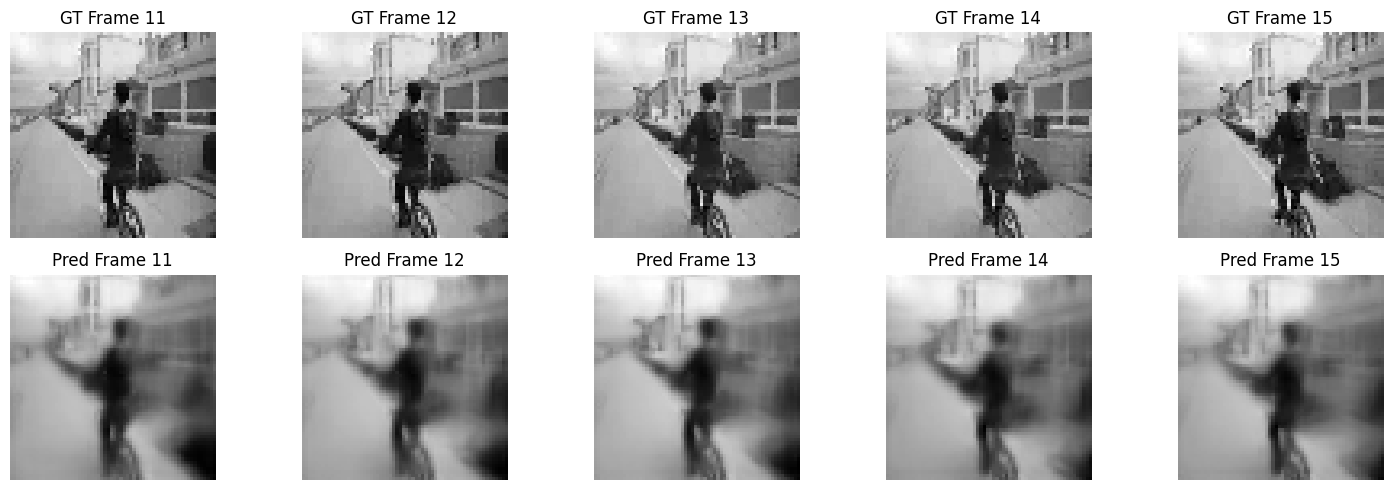

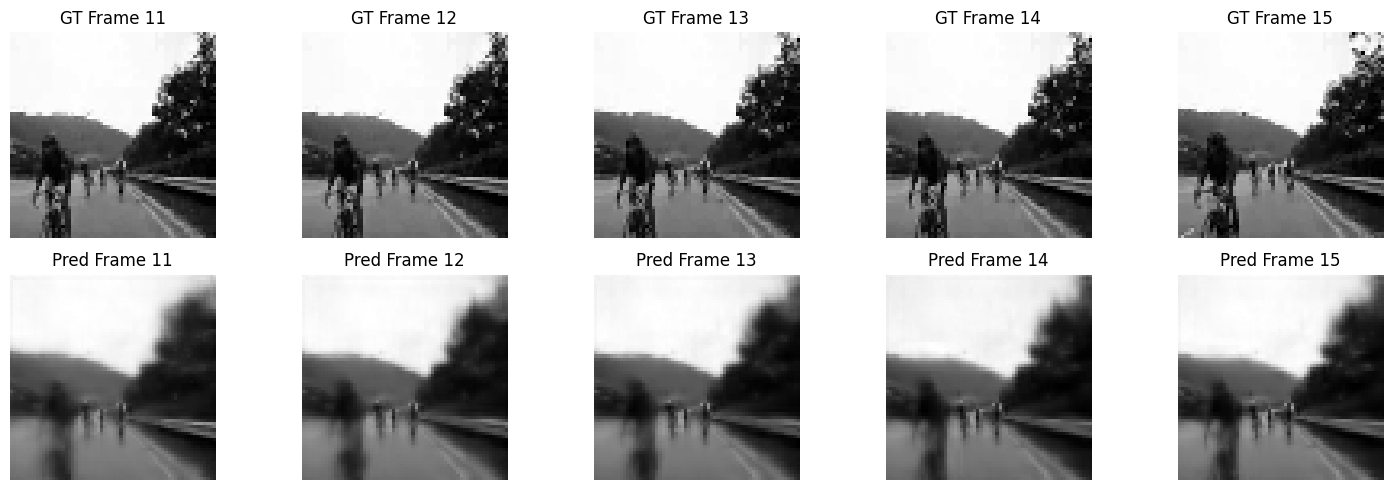

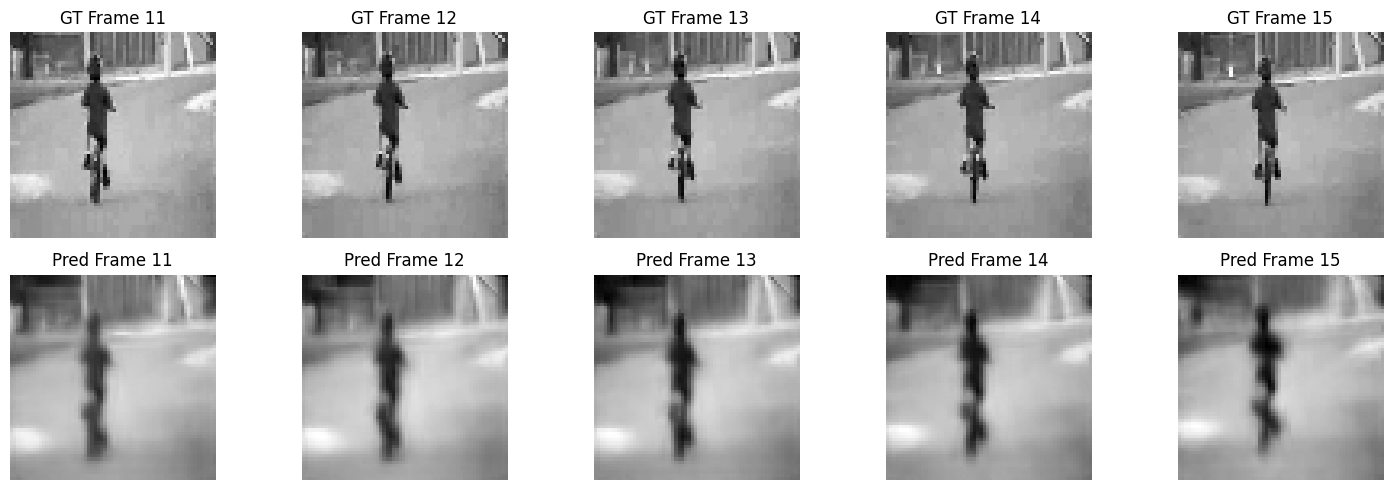

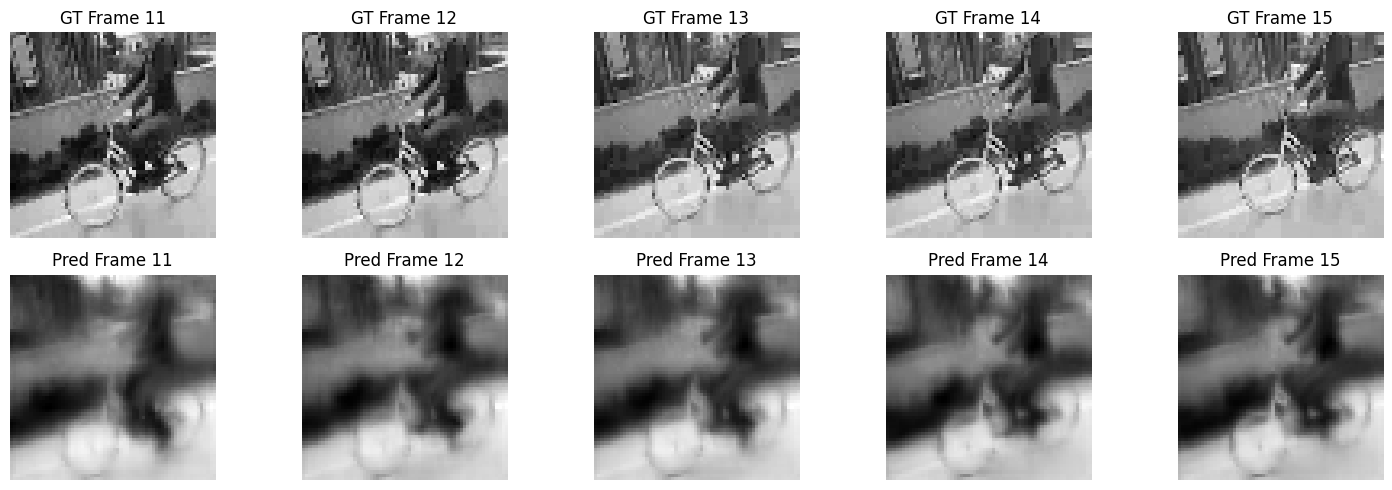

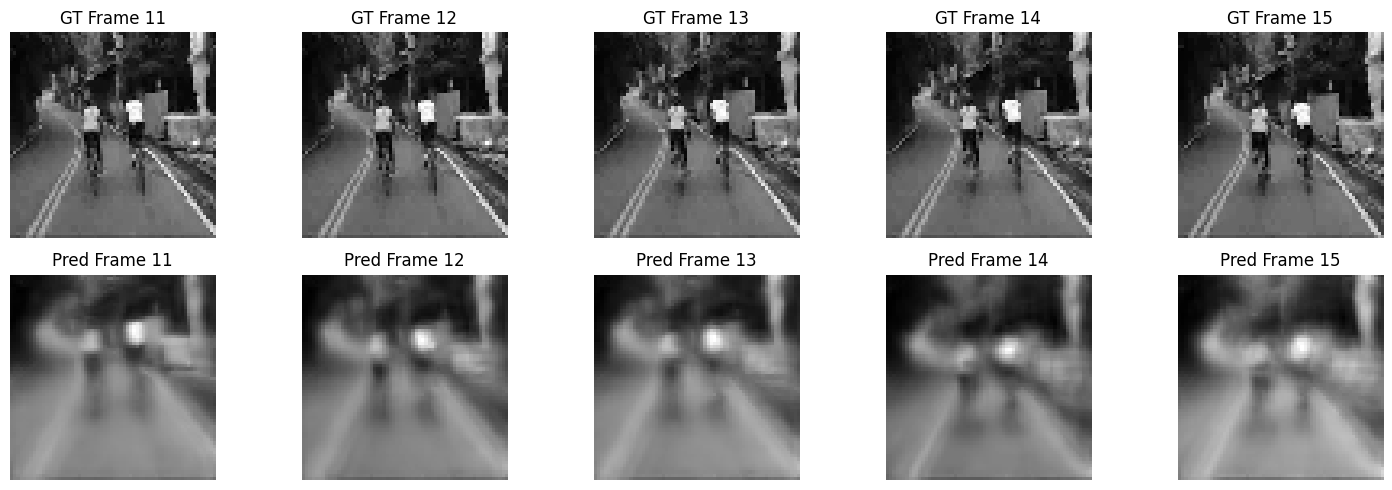

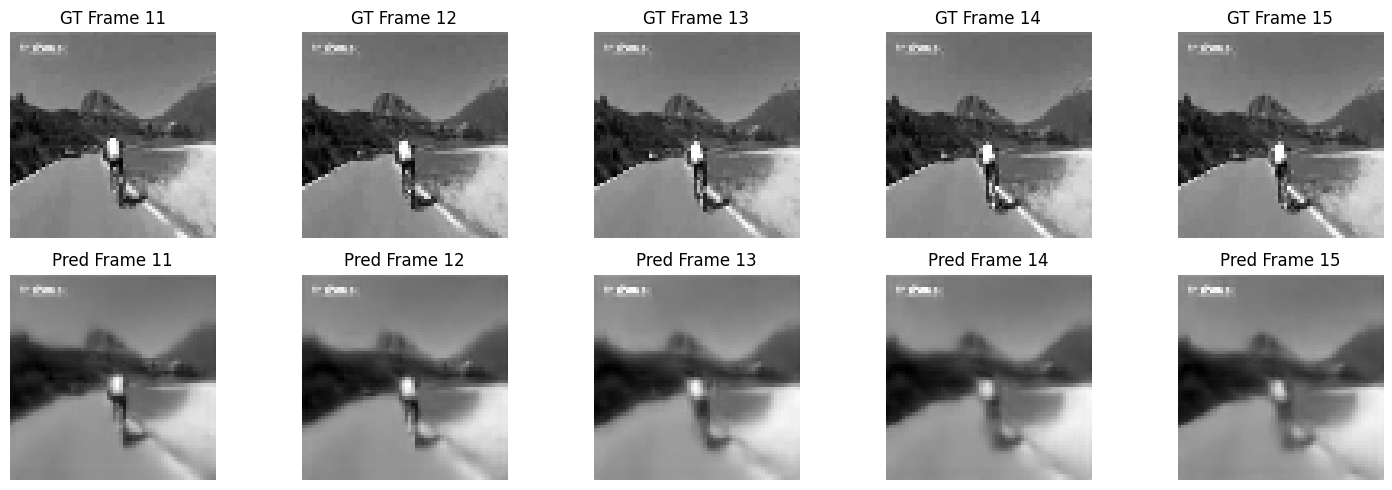

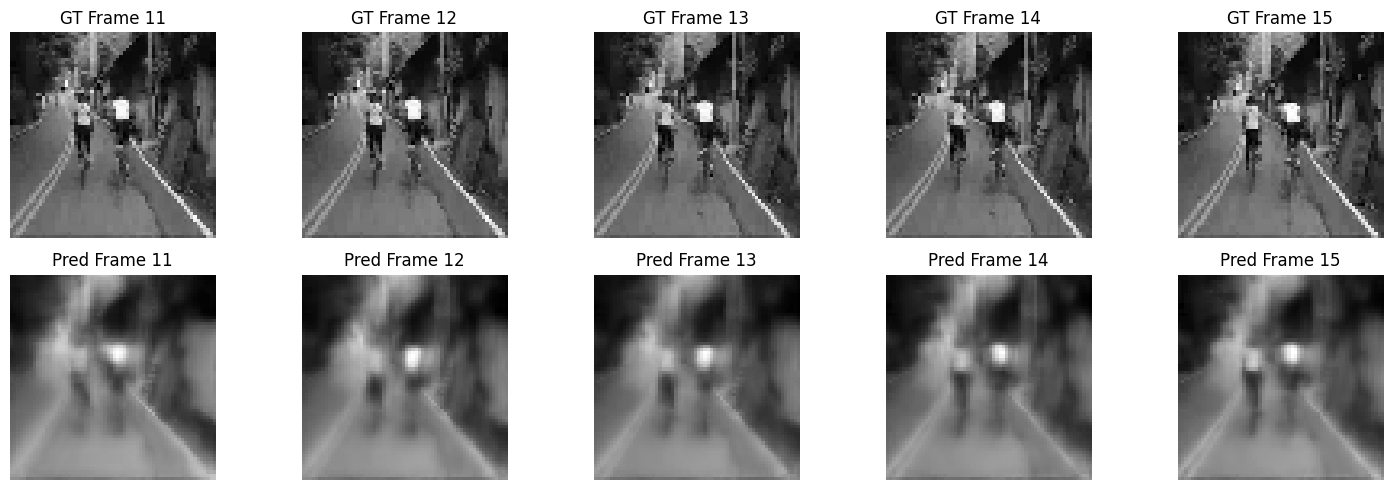

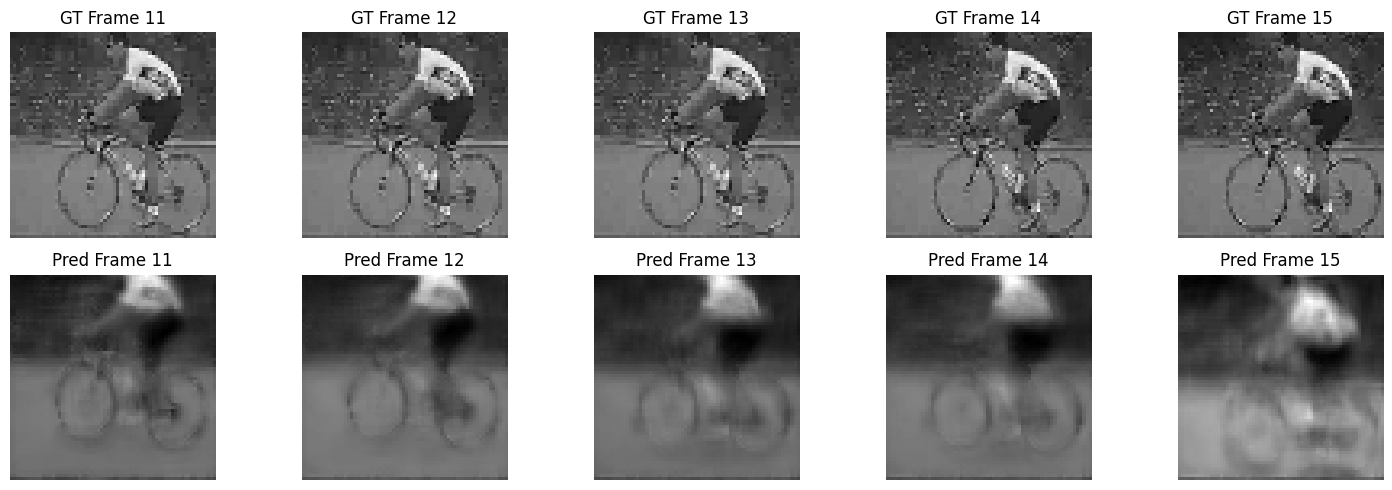

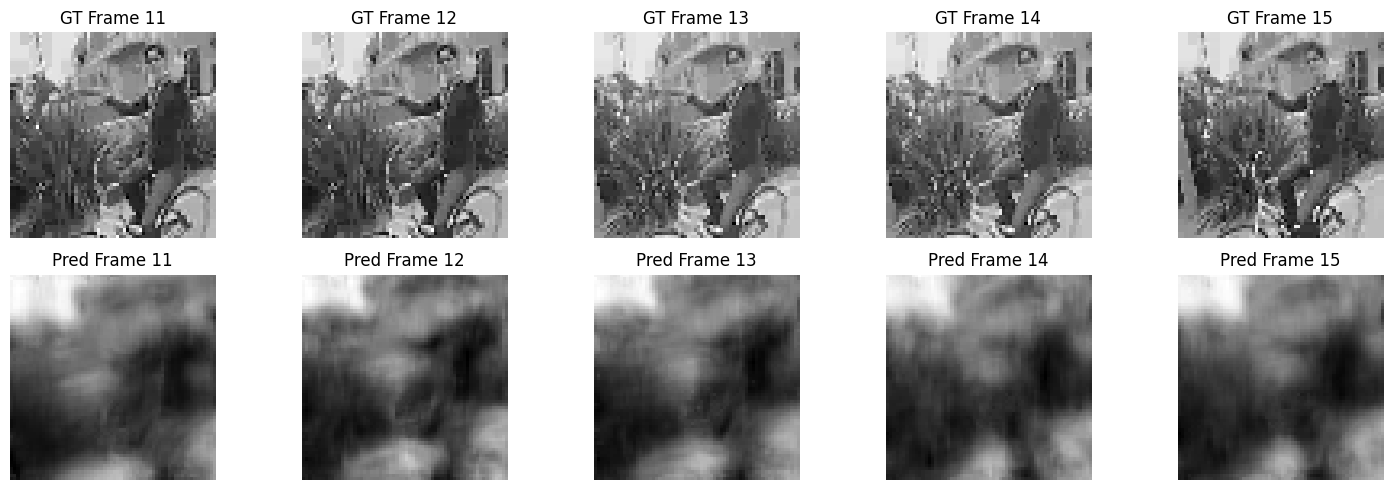

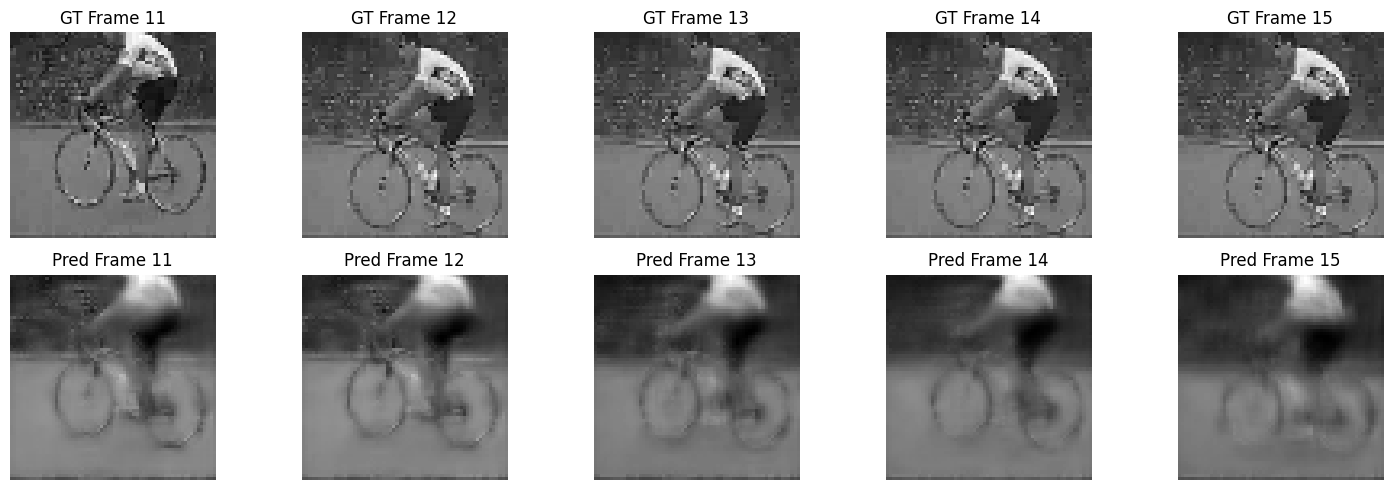

In [ ]:
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.cpu().numpy()
        outputs = model(inputs).cpu().numpy()  # Predict all 5 frames

        # Visualize results
        for batch_idx in range(outputs.shape[0]):
            plt.figure(figsize=(15, 5))
            for frame_idx in range(5):
                # Ground Truth
                plt.subplot(2, 5, frame_idx + 1)
                plt.imshow(targets[batch_idx, frame_idx, 0], cmap="gray")
                plt.title(f"GT Frame {frame_idx + 11}")
                plt.axis("off")

                # Predicted Frame
                plt.subplot(2, 5, frame_idx + 6)
                plt.imshow(outputs[batch_idx, frame_idx, 0], cmap="gray")
                plt.title(f"Pred Frame {frame_idx + 11}")
                plt.axis("off")

            plt.tight_layout()
            plt.show()
            break  # Show results for the first batch

---

### **Conclusion**

---

**In evaluating the performance of the ConvLSTM model, two key metrics were used. Mean Squared Error (MSE) and Structural Similarity Index (SSIM).**

1. The model achieved an MSE of 0.0113, indicating that the predicted frames are relatively close to the ground truth with minimal error. 

2. The SSIM score of 0.6349 suggests that while the predicted frames retain some structural similarities to the original frames, there is still noticeable room for improvement, particularly in terms of finer details and texture preservation. 


**These results show that the ConvLSTM model performs reasonably well but could benefit from further optimization to improve frame quality and structural fidelity.**

---